For the RDAI: Foundations of Deep Learning Project, my focus will be on evaluating the effectiveness of deep learning models in classifying human emotions based on facial expression images.

The dataset that I will be using is a subset of the AffectNet dataset, sourced from Kaggle: https://www.kaggle.com/datasets/mstjebashazida/affectnet

This subset includes 28,175 color images, each sized at 96x96 pixels.

The dataset is categorized into 8 emotion classes:

1.   Anger
2.   Contempt
3.   Disgust
4.   Fear
5.   Happiness
6.   Neutral
7.   Sadness
8.   Surprise

For the experiment, 22,540 images will be allocated for training, 2,817 for validation, and 2,818 for testing.

## Import libraries

In [81]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import zipfile
from collections import Counter

from PIL import Image
import cv2

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
from torch.utils.data import Dataset

%matplotlib inline
sns.set_style("whitegrid")

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Data Preparation

In [7]:
with zipfile.ZipFile('/content/drive/MyDrive/facial_emotion_recognition_dataset.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/facial_emotion_recognition')

In [18]:
# Rename directory to lowercase for consistency
os.rename('/content/facial_emotion_recognition/archive (3)/Test/Anger', '/content/facial_emotion_recognition/archive (3)/Test/anger')
os.rename('/content/facial_emotion_recognition/archive (3)/Test/Contempt', '/content/facial_emotion_recognition/archive (3)/Test/contempt')

In [26]:
classes = os.listdir("/content/facial_emotion_recognition/archive (3)/Train")

train_dir = "/content/facial_emotion_recognition/archive (3)/Train"
test_dir = "/content/facial_emotion_recognition/archive (3)/Test"

def determine_train_or_test(file_path):
    train_path = os.path.join(train_dir, file_path)
    test_path = os.path.join(test_dir, file_path)

    if os.path.exists(train_path):
        return 'Train'
    elif os.path.exists(test_path):
        return 'Test'
    else:
        return 'Not Found'

## Load dataset

In [27]:
df = pd.read_csv("/content/facial_emotion_recognition/archive (3)/labels.csv", index_col=0)
df

,pth,label,relFCs
0,anger/image0000006.jpg,surprise,0.873142
1,anger/image0000060.jpg,anger,0.852311
2,anger/image0000061.jpg,anger,0.800957
3,anger/image0000066.jpg,disgust,0.843079
4,anger/image0000106.jpg,anger,0.849108
...,...,...,...
28170,surprise/image0034960.jpg,surprise,0.825263
28171,surprise/image0034961.jpg,surprise,0.738646
28172,surprise/image0034966.jpg,surprise,0.774524
28173,surprise/image0034973.jpg,neutral,0.766952


## Determine whether image filepath in dataset belongs to Train or Test

In [28]:
df['dataset'] = df['pth'].apply(determine_train_or_test)
df['pth'] = df['dataset'].str.cat(df['pth'], sep='/')

In [29]:
df

,pth,label,relFCs,dataset
0,Test/anger/image0000006.jpg,surprise,0.873142,Test
1,Test/anger/image0000060.jpg,anger,0.852311,Test
2,Test/anger/image0000061.jpg,anger,0.800957,Test
3,Test/anger/image0000066.jpg,disgust,0.843079,Test
4,Test/anger/image0000106.jpg,anger,0.849108,Test
...,...,...,...,...
28170,Train/surprise/image0034960.jpg,surprise,0.825263,Train
28171,Train/surprise/image0034961.jpg,surprise,0.738646,Train
28172,Train/surprise/image0034966.jpg,surprise,0.774524,Train
28173,Train/surprise/image0034973.jpg,neutral,0.766952,Train


## EDA

In [30]:
counts_train_df = pd.DataFrame.from_dict(dict(Counter(df[df["dataset"] == "Train"].label)), orient='index', columns=['count']).sort_values('count', ascending=False)
counts_test_df = pd.DataFrame.from_dict(dict(Counter(df[df["dataset"] == "Test"].label)), orient='index', columns=['count']).sort_values('count', ascending=False)

combined_counts_df = pd.concat([counts_train_df.assign(dataset='Train'),
                                counts_test_df.assign(dataset='Test')])
combined_counts_df = combined_counts_df.reset_index().rename(columns={'index': 'emotion'})

In [31]:
combined_counts_df

,emotion,count,dataset
0,surprise,2398,Train
1,sad,2395,Train
2,happy,2063,Train
3,anger,1930,Train
4,disgust,1792,Train
5,contempt,1776,Train
6,neutral,1627,Train
7,fear,1598,Train
8,happy,2273,Test
9,surprise,2218,Test


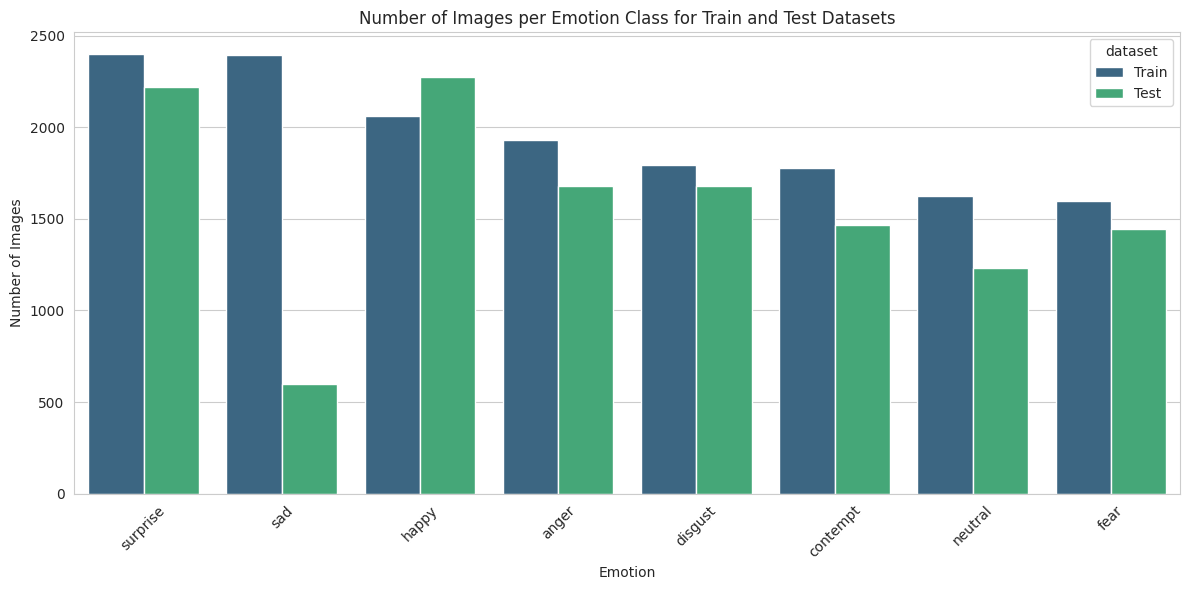

In [32]:
plt.figure(figsize=(12, 6))
sns.barplot(x='emotion', y='count', hue='dataset', data=combined_counts_df, palette='viridis')
plt.xticks(rotation=45)
plt.title("Number of Images per Emotion Class for Train and Test Datasets")
plt.ylabel("Number of Images")
plt.xlabel("Emotion")
plt.tight_layout()
plt.show()

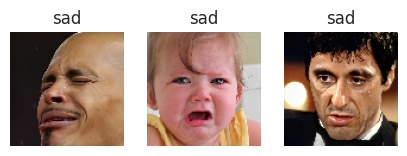

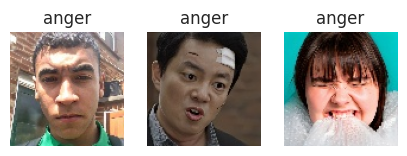

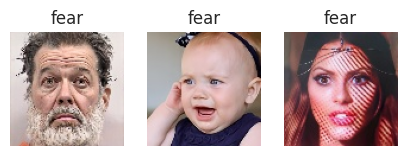

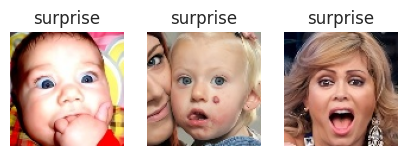

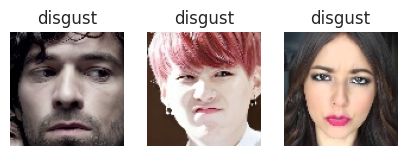

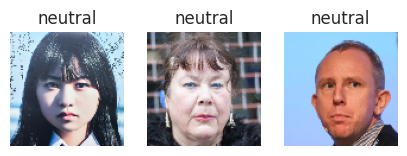

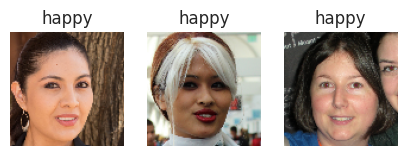

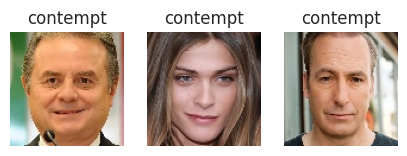

In [33]:
def show_random_train_images(emotion, num=5):
    fig, axes = plt.subplots(1, num, figsize=(5,5))
    class_dir = os.path.join(train_dir, emotion)
    imgs = os.listdir(class_dir)
    sampled = np.random.choice(imgs, size=num, replace=False)
    for ax, img_name in zip(axes, sampled):
        img_path = os.path.join(class_dir, img_name)
        img = Image.open(img_path)
        ax.imshow(img.convert('RGB'))
        ax.axis('off')
        ax.set_title(emotion)
    plt.show()

for emo in classes:
    show_random_train_images(emo, num=3)

Unique sizes: [[96 96]]
Width: mean, min, max: 96.0 96 96
Height: mean, min, max: 96.0 96 96


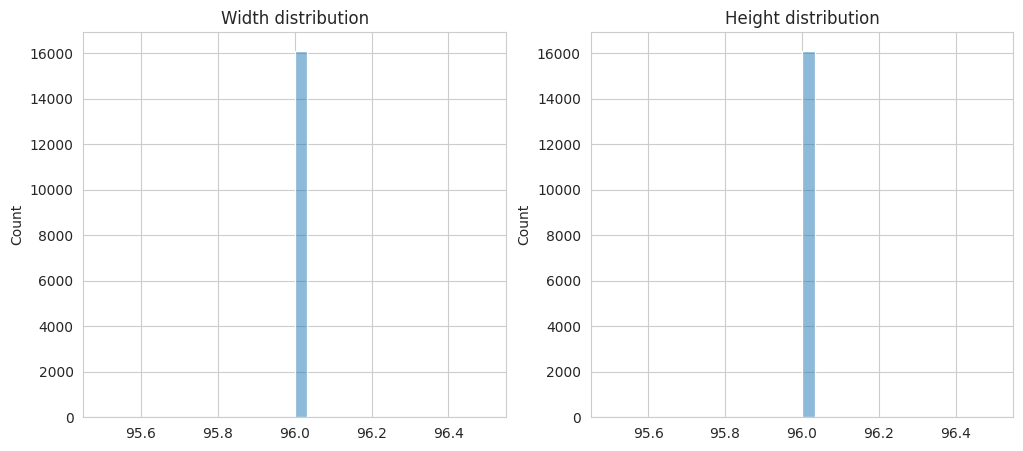

In [34]:
# Collect image sizes to see variation
size_list = []
for emo in classes:
    class_dir = os.path.join(train_dir, emo)
    for fname in os.listdir(class_dir):
        fpath = os.path.join(class_dir, fname)
        try:
            img = Image.open(fpath)
            size_list.append(img.size)  # (width, height)
        except Exception as e:
            print("Error with image:", fpath, e)

size_arr = np.array(size_list)
print("Unique sizes:", np.unique(size_arr, axis=0))
print("Width: mean, min, max:", size_arr[:,0].mean(), size_arr[:,0].min(), size_arr[:,0].max())
print("Height: mean, min, max:", size_arr[:,1].mean(), size_arr[:,1].min(), size_arr[:,1].max())

# Histogram of sizes
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
sns.histplot(size_arr[:,0], bins=30, kde=True)
plt.title("Width distribution")
plt.subplot(1,2,2)
sns.histplot(size_arr[:,1], bins=30, kde=True)
plt.title("Height distribution")
plt.show()


In [35]:
# Check whether 1. images are grayscale or RGB and 2. any corrupted
def check_colour_corrupted(directory):
  channels = []
  bad_images = []
  for emo in classes:
      class_dir = os.path.join(directory, emo)
      for fname in os.listdir(class_dir):
          fpath = os.path.join(class_dir, fname)
          try:
              img = Image.open(fpath)
              arr = np.array(img)
              if arr.ndim == 2:
                  channels.append('grayscale')
              elif arr.ndim == 3:
                  channels.append('color')
              else:
                  channels.append('other')
          except Exception as e:
              bad_images.append(fpath)

  print("Bad / unreadable images:", len(bad_images))
  print("Channels distribution:", pd.Series(channels).value_counts())

check_colour_corrupted(train_dir)
print("------------------------------------")
check_colour_corrupted(test_dir)

Bad / unreadable images: 0
Channels distribution: color    16108
Name: count, dtype: int64
------------------------------------
Bad / unreadable images: 0
Channels distribution: color    14518
Name: count, dtype: int64


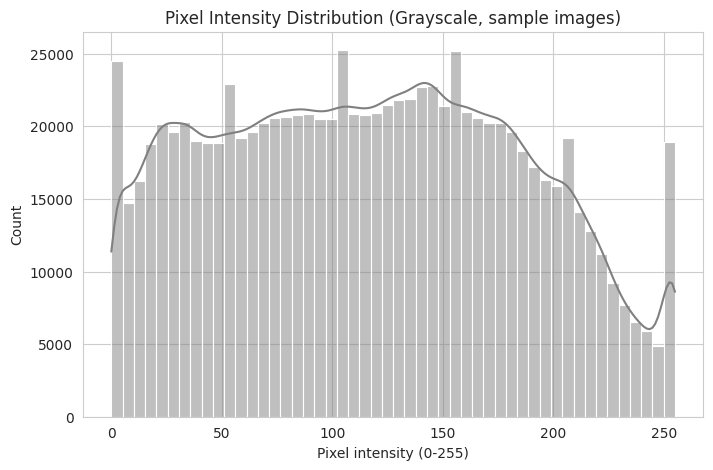

In [36]:
# Take sample of images to compute pixel value distributions
def get_pixel_values(sample_paths, resize_to=(48,48)):
    vals = []
    for fpath in sample_paths:
        img = Image.open(fpath).convert('L')  # grayscale
        img = img.resize(resize_to)
        arr = np.array(img).flatten()
        vals.extend(arr)
    return np.array(vals)

# Collect sample image paths
sample_paths = []
for emo in classes:
    class_dir = os.path.join(train_dir, emo)
    imgs = os.listdir(class_dir)
    selected = np.random.choice(imgs, size=min(50, len(imgs)), replace=False)
    sample_paths += [os.path.join(class_dir, fname) for fname in selected]

pix_vals = get_pixel_values(sample_paths)
plt.figure(figsize=(8,5))
sns.histplot(pix_vals, bins=50, kde=True, color='gray')
plt.title("Pixel Intensity Distribution (Grayscale, sample images)")
plt.xlabel("Pixel intensity (0‑255)")
plt.show()

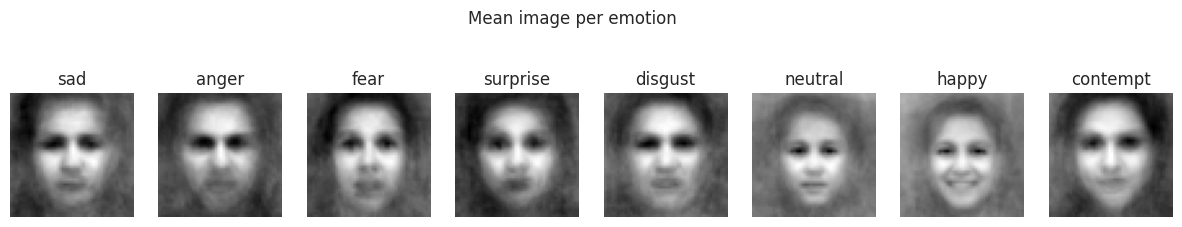

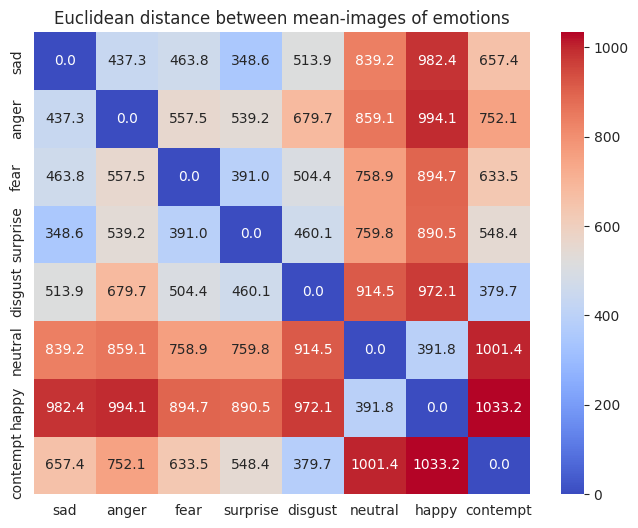

In [37]:
# Mean images
mean_images = {}
resize_to = (48,48)
for emo in classes:
    class_dir = os.path.join(train_dir, emo)
    imgs = os.listdir(class_dir)
    selected = np.random.choice(imgs, size=min(100, len(imgs)), replace=False)
    accum = np.zeros((resize_to[1], resize_to[0]), dtype=np.float32)
    for fname in selected:
        img = Image.open(os.path.join(class_dir, fname)).convert('L').resize(resize_to)
        accum += np.array(img, dtype=np.float32)
    mean = accum / len(selected)
    mean_images[emo] = mean

# Plot mean images
n = len(classes)
plt.figure(figsize=(15, 3))
for i, emo in enumerate(classes):
    plt.subplot(1, n, i+1)
    plt.imshow(mean_images[emo], cmap='gray')
    plt.title(emo)
    plt.axis('off')
plt.suptitle("Mean image per emotion")
plt.show()

# Compute pairwise distances
from scipy.spatial.distance import pdist, squareform

stack = np.stack([mean_images[emo].flatten() for emo in classes])
dists = squareform(pdist(stack, metric='euclidean'))
dists_df = pd.DataFrame(dists, index=classes, columns=classes)
plt.figure(figsize=(8,6))
sns.heatmap(dists_df, annot=True, fmt=".1f", cmap='coolwarm')
plt.title("Euclidean distance between mean‑images of emotions")
plt.show()

## Train, Val, Test Split

In [38]:
# Convert labels to numerical using Label Encoding
label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['label'])

# Add full filepath
df["pth"] = df["pth"].apply(lambda x: os.path.join("/content/facial_emotion_recognition/archive (3)", x))

# Split data into 80% train, 10% validation, 10% test
train_df, temp = train_test_split(
    df,
    test_size=0.2,
    random_state=42,
    stratify=df['label']
)
val_df, test_df = train_test_split(
    temp,
    test_size=0.5,
    random_state=42,
    stratify=temp['label']
)

In [39]:
train_df

,pth,label,relFCs,dataset
16932,/content/facial_emotion_recognition/archive (3...,5,0.766513,Test
26260,/content/facial_emotion_recognition/archive (3...,7,0.838965,Train
21408,/content/facial_emotion_recognition/archive (3...,6,0.677089,Train
11526,/content/facial_emotion_recognition/archive (3...,1,0.785261,Test
4771,/content/facial_emotion_recognition/archive (3...,1,0.850632,Train
...,...,...,...,...
2153,/content/facial_emotion_recognition/archive (3...,5,0.800394,Train
21936,/content/facial_emotion_recognition/archive (3...,6,0.744659,Train
17943,/content/facial_emotion_recognition/archive (3...,5,0.832933,Train
13939,/content/facial_emotion_recognition/archive (3...,4,0.813391,Train


In [40]:
class AffectNetDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        """
        Args:
            dataframe (pd.DataFrame): DataFrame with columns ['filepath', 'label']
            transform (callable, optional): Optional transform to be applied on an image.
        """
        self.df = dataframe.reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = self.df.loc[idx, 'pth']
        label = int(self.df.loc[idx, 'label'])

        # Load image
        image = Image.open(img_path).convert('RGB')

        # Apply transformations
        if self.transform:
            image = self.transform(image)

        return image, label


In [60]:
# Hyperparams
batch_size = 64
img_size = 128

# Data transforms
train_transforms = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# Datasets + loaders
train_dataset = AffectNetDataset(dataframe=train_df, transform=train_transforms)
val_dataset = AffectNetDataset(dataframe=val_df, transform=val_transforms)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

## Model 1: CNN

In [62]:
class EmotionCNN(nn.Module):
    def __init__(self, num_classes=8):
        super(EmotionCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        flattened_size = 128 * 16 * 16

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(flattened_size, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = EmotionCNN(num_classes=8).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

patience = 5
best_val_loss = float('inf')
epochs_without_improvement = 0
max_epochs = 30

cnn_train_losses = []
cnn_val_losses = []

for epoch in range(max_epochs):
    # -------------------- TRAINING --------------------
    model.train()
    train_loss = 0.0
    train_correct = 0
    train_total = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        train_total += labels.size(0)
        train_correct += (preds == labels).sum().item()

    train_acc = 100 * train_correct / train_total
    train_loss /= len(train_loader)

    # -------------------- VALIDATION --------------------
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (preds == labels).sum().item()

    val_acc = 100 * val_correct / val_total
    val_loss /= len(val_loader)

    print(f"Epoch [{epoch+1}/{max_epochs}] "
          f"Train Loss: {train_loss:.4f}, Acc: {train_acc:.2f}% | "
          f"Val Loss: {val_loss:.4f}, Acc: {val_acc:.2f}%")

    cnn_train_losses.append(train_loss)
    cnn_val_losses.append(val_loss)

    # -------------------- EARLY STOPPING --------------------
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_without_improvement = 0
        torch.save(model.state_dict(), "cnn_best_model.pth")
    else:
        epochs_without_improvement += 1

    if epochs_without_improvement >= patience:
        print(f"Early stopping triggered at epoch {epoch+1}")
        break

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch [1/30] Train Loss: 1.9058, Acc: 26.88% | Val Loss: 1.6528, Acc: 38.05%
Epoch [2/30] Train Loss: 1.5819, Acc: 40.65% | Val Loss: 1.4236, Acc: 46.82%
Epoch [3/30] Train Loss: 1.4363, Acc: 46.40% | Val Loss: 1.3441, Acc: 50.48%
Epoch [4/30] Train Loss: 1.3744, Acc: 49.13% | Val Loss: 1.2820, Acc: 52.79%
Epoch [5/30] Train Loss: 1.3141, Acc: 50.91% | Val Loss: 1.3014, Acc: 52.72%
Epoch [6/30] Train Loss: 1.2777, Acc: 52.30% | Val Loss: 1.2200, Acc: 55.38%
Epoch [7/30] Train Loss: 1.2423, Acc: 54.07% | Val Loss: 1.1666, Acc: 56.73%
Epoch [8/30] Train Loss: 1.2149, Acc: 55.44% | Val Loss: 1.1367, Acc: 57.40%
Epoch [9/30] Train Loss: 1.1810, Acc: 56.24% | Val Loss: 1.1401, Acc: 58.54%
Epoch [10/30] Train Loss: 1.1623, Acc: 57.21% | Val Loss: 1.1178, Acc: 58.82%
Epoch [11/30] Train Loss: 1.1461, Acc: 57.64% | Val Loss: 1.1188, Acc: 58.86%
Epoch [12/30] Train Loss: 1.1328, Acc: 57.90% | Val Loss: 1.1026, Acc: 59.18%
Epoch [13/30] Train Loss: 1.1098, Acc: 58.72% | Val Loss: 1.0766, Acc: 59

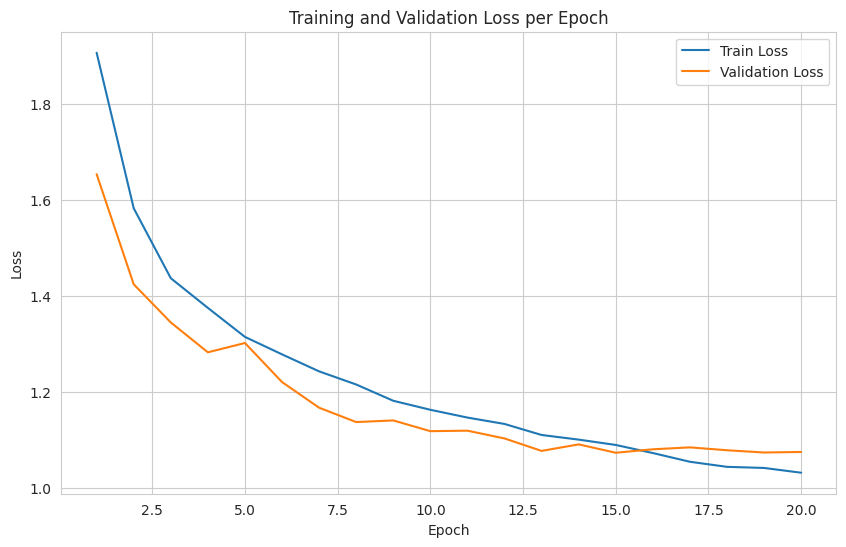

In [64]:
# Loss plot
plt.figure(figsize=(10, 6))
plt.plot(range(1, epoch + 2), cnn_train_losses, label='Train Loss')
plt.plot(range(1, epoch + 2), cnn_val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss per Epoch')
plt.legend()
plt.grid(True)
plt.show()

In [78]:
test_dataset = AffectNetDataset(dataframe=test_df, transform=val_transforms)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

# Evaluate the model on the test set
model.eval()
test_correct = 0
test_total = 0
preds, truth = [], []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Forward pass
        outputs = model(inputs)

        # Get predictions
        _, predicted = torch.max(outputs, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

        preds.extend(predicted.cpu().numpy())
        truth.extend(labels.cpu().numpy())

test_accuracy = 100 * test_correct / test_total
print(f"CNN Accuracy: {test_accuracy:.2f}%")

CNN Accuracy: 60.50%


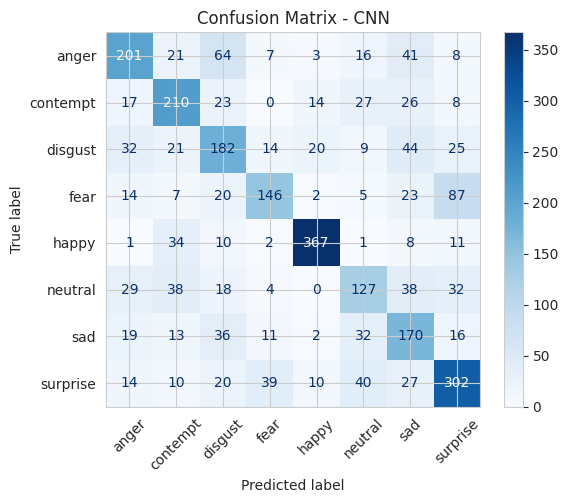

In [92]:
# Generate confusion matrix
cm = confusion_matrix(truth, preds)
# Convert numerical labels back to emotion names
class_names = label_encoder.inverse_transform(list(set(test_dataset.df.label)))

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
fig, ax = plt.subplots(figsize=(6, 5))
disp.plot(ax=ax, cmap='Blues', xticks_rotation=45)
plt.title('Confusion Matrix - CNN')
plt.tight_layout()
plt.show()

## Model 2: Pre-trained VGG16 model

In [50]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Load pre-trained VGG-16 model
vgg16 = torchvision.models.vgg16(pretrained=True)

vgg16.classifier[6] = nn.Linear(in_features=4096, out_features=8)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vgg16.to(device)

# Define loss function & optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(vgg16.parameters(), lr=0.0001)

# Early stopping parameters
patience = 5
best_val_loss = float('inf')
epochs_without_improvement = 0
max_epochs = 30

train_losses = []
val_losses = []

for epoch in range(max_epochs):
    vgg16.train()   # Set model to training mode
    running_loss = 0.0
    correct = 0
    total = 0

    # Training loop
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = vgg16(inputs)

        # Compute loss
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Get predictions
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_accuracy = 100 * correct / total

    # Validation loop
    vgg16.eval()  # Set model to evaluation mode
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            outputs = vgg16(inputs)

            # Compute loss
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            # Get predictions
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_loss_avg = val_loss / len(val_loader)
    val_accuracy = 100 * val_correct / val_total

    print(f"Epoch [{epoch+1}/{max_epochs}], Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, "
          f"Val Loss: {val_loss_avg:.4f}, Val Accuracy: {val_accuracy:.2f}%")

    train_losses.append(train_loss)
    val_losses.append(val_loss_avg)

    # Early stopping check
    if val_loss_avg < best_val_loss:
        best_val_loss = val_loss_avg
        epochs_without_improvement = 0
        torch.save(vgg16.state_dict(), 'vgg16_best_model.pth')
    else:
        epochs_without_improvement += 1

    if epochs_without_improvement >= patience:
        print(f"Early stopping at epoch {epoch+1}")
        break


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker n

Epoch [1/30], Train Loss: 1.4084, Train Accuracy: 46.46%, Val Loss: 1.1617, Val Accuracy: 57.69%
Epoch [2/30], Train Loss: 0.9721, Train Accuracy: 64.37%, Val Loss: 0.9497, Val Accuracy: 66.28%
Epoch [3/30], Train Loss: 0.8243, Train Accuracy: 69.44%, Val Loss: 0.8823, Val Accuracy: 68.65%
Epoch [4/30], Train Loss: 0.7164, Train Accuracy: 73.54%, Val Loss: 0.8701, Val Accuracy: 69.08%
Epoch [5/30], Train Loss: 0.6323, Train Accuracy: 76.79%, Val Loss: 0.8457, Val Accuracy: 70.71%
Epoch [6/30], Train Loss: 0.5486, Train Accuracy: 79.92%, Val Loss: 0.8221, Val Accuracy: 71.74%
Epoch [7/30], Train Loss: 0.4928, Train Accuracy: 82.02%, Val Loss: 0.8767, Val Accuracy: 71.85%
Epoch [8/30], Train Loss: 0.4393, Train Accuracy: 84.02%, Val Loss: 0.8100, Val Accuracy: 72.28%
Epoch [9/30], Train Loss: 0.3875, Train Accuracy: 86.15%, Val Loss: 0.9405, Val Accuracy: 71.00%
Epoch [10/30], Train Loss: 0.3277, Train Accuracy: 88.32%, Val Loss: 0.9727, Val Accuracy: 71.18%
Epoch [11/30], Train Loss: 0.

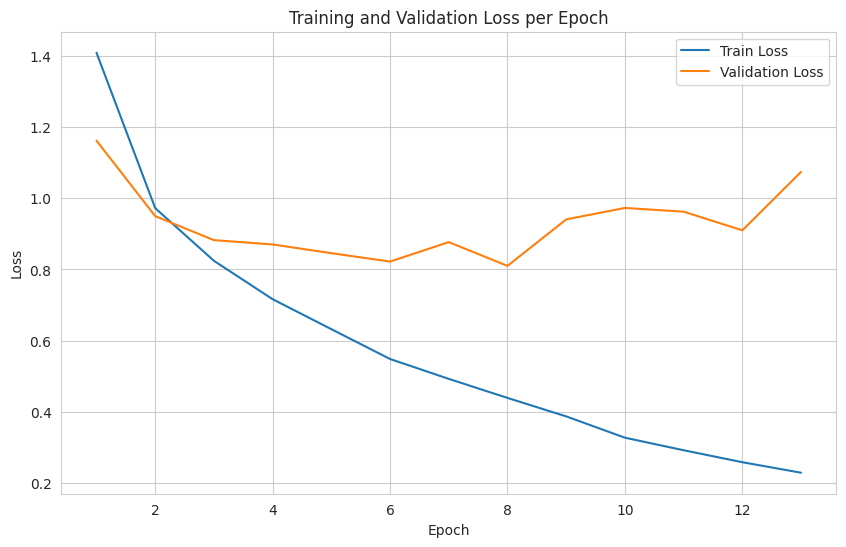

In [56]:
# Loss plot
plt.figure(figsize=(10, 6))
plt.plot(range(1, epoch + 2), train_losses, label='Train Loss')
plt.plot(range(1, epoch + 2), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss per Epoch')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
vgg16.load_state_dict(torch.load('vgg16_best_model.pth'))

In [93]:
test_dataset = AffectNetDataset(dataframe=test_df, transform=val_transforms)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

# Evaluate the model on the test set
vgg16.eval()
test_correct = 0
test_total = 0
preds, truth = [], []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Forward pass
        outputs = vgg16(inputs)

        # Get predictions
        _, predicted = torch.max(outputs, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

        preds.extend(predicted.cpu().numpy())
        truth.extend(labels.cpu().numpy())

test_accuracy = 100 * test_correct / test_total
print(f"VGG16 Accuracy: {test_accuracy:.2f}%")

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


VGG16 Accuracy: 72.32%


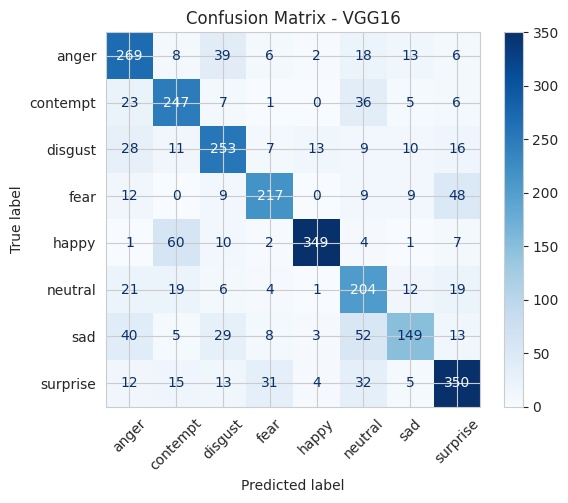

In [94]:
# Generate confusion matrix
cm = confusion_matrix(truth, preds)
# Convert numerical labels back to emotion names
class_names = label_encoder.inverse_transform(list(set(test_dataset.df.label)))

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
fig, ax = plt.subplots(figsize=(6, 5))
disp.plot(ax=ax, cmap='Blues', xticks_rotation=45)
plt.title('Confusion Matrix - VGG16')
plt.tight_layout()
plt.show()

## Conclusion

The custom CNN model achieved a test accuracy of **60.5%**, which indicates that while the model was able to learn meaningful patterns from the data, its performance is relatively limited.

In contrast, the VGG16 model, which was pre-trained on the ImageNet dataset and then fine-tuned on this emotion classification task, achieved a significantly higher test accuracy of **72.32%**. This improvement demonstrates the power of transfer learning, especially when working with a limited dataset.

Overall, this project demonstrates that deep learning, particularly when enhanced through transfer learning, can be a powerful tool for facial emotion recognition. However, achieving truly robust performance will require more advanced techniques and possibly more diverse training data.